# **Import Libraries**

In [73]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split  # Membagi dataset menjadi data latih dan data uji

import datetime as dt  # Manipulasi data waktu dan tanggal
import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Data Loading and Cleaning**

In [3]:
df = pd.read_csv('app_review2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              103500 non-null  object
 1   userName              103500 non-null  object
 2   userImage             103500 non-null  object
 3   content               103500 non-null  object
 4   score                 103500 non-null  int64 
 5   thumbsUpCount         103500 non-null  int64 
 6   reviewCreatedVersion  75272 non-null   object
 7   at                    103500 non-null  object
 8   replyContent          3444 non-null    object
 9   repliedAt             3444 non-null    object
 10  appVersion            75272 non-null   object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB


In [4]:
df.shape

(103500, 11)

In [5]:
review = df[['content']].copy()
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  103500 non-null  object
dtypes: object(1)
memory usage: 808.7+ KB


In [6]:
review.duplicated().sum()

np.int64(69)

In [7]:
review = review.drop_duplicates()
review.duplicated().sum()

np.int64(0)

In [41]:
reviews = review.sample(n=12000, random_state=44).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
reviews.head(10)

,content
0,"kenapa tiktok sering sekali tidak bisa di buka selalu ngestak di logo tiktok,sering sekali harus ulang download apk tiktok,gara' tidak bisa di buka,benerin dong bug tiktokny jadi olok kuota,makasi"
1,"suka banget dengan update an tiktok sekarang, Setiap menonton video, ada koin. jadi koinnya bisa bertambah lagi deh.... kalau mau update jangan lupa ditambah dengan koin seperti ini ya kak, biar rajin nonton 😁"
2,aku pikir hp ku yg eror.memory full. sampai2 bnyk aplikasi yg tak hapus. tik tok tak hapus lalu download lg eh jg sama saja ndak bisa masuk mohon segera perbaiki ya tik tok aq sepi tanpamu 🤗🤗..
3,sering ngebug cuma ngestak di logo tolong di perbaikin saya cuma berharap itu saja
4,saya sangat suka namun terkadang akun saya terkena pelanggaran padahal saya gak ngapain ngapian aneh kan
5,jujur agak nge leg tapi gpp sih ya 4 lah menurut ku tolong di update lagi ya
6,"itu buat yang selalu ngeleg tolong jangan salahin tik tok nya salahin HP sendiri, kalo gamau ngeleg ganti HP nya huuh"
7,Untuk event berhadiah tolong tidak hanya di akun pertama tapi juga ke akun kedua dan seterusnya punya ku tidak bisa tolong tik tok
8,kok nggak ada shopnya aku mau belanja di tiktok susah🙂
9,"makin kesini makin gak ngerti sering banget aplikasinya gak bisa dibuka cuma muncul logo tiktok nya doang,,ujung²nya harus re-instal lagi🤦‍♀️"


# **Data Preprocessing**

### **Functions for data preprocessing**

In [44]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text) 
    text = re.sub(r'RT[\s]', '', text) 
    text = re.sub(r"http\S+", '', text) 
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[,.\/]', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'[²]+', '', text)
    text = text.replace('\n', ' ') 
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ') 
    return text

def casefoldingText(text): 
    text = text.lower()
    return text

def tokenizingText(text): 
    text = word_tokenize(text)
    return text

def filteringText(text): 
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {"apk" : "aplikasi", "ngestak" : "stuck", "tiktokny" : "tiktoknya", "eror" : "error", "ngapian" : "ngapain", "olok" : "boros",  "donk" : "dong", "plis" : "tolong", "tiktokk" : "tiktok", "cuan" : "uang", "tampa" : "tanpa", "crol" : "scroll", "ngestack" : "stuck", "blaja" : "belanja", "pas" : "saat", "g" : "tidak", "gk": "tidak", "ga": "tidak", "gak": "tidak", "ngga": "tidak", "bgt": "banget", "aj": "saja", "aja": "saja", "trs": "terus","klo": "kalau", "kalo": "kalau", "sm": "sama", "bener2": "benar","mantul": "mantap", "keren": "bagus", "jd": "jadi", "yg": "yang","dgn": "dengan", "udh": "sudah", "sdh": "sudah", "emg": "memang","mkn": "makan", "tp": "tetapi", "bru": "baru", "cepet": "cepat","parah": "sekali", "makasih": "terima kasih", "trims": "terima kasih","ngelag": "lambat", "lemot": "lambat", "crash": "rusak", "error": "rusak","ok": "oke", "okee": "oke", "okey": "oke", "sip": "baik","banget": "sekali", "bgs": "bagus", "tdk": "tidak", "jg": "juga", "@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

### **Apply functions to data**

In [45]:
reviews['text_clean'] = reviews['content'].apply(cleaningText)
reviews['text_casefoldingText'] = reviews['text_clean'].apply(casefoldingText)
reviews['text_slangwords'] = reviews['text_casefoldingText'].apply(fix_slangwords)
reviews['text_tokenizingText'] = reviews['text_slangwords'].apply(tokenizingText)
reviews['text_stopword'] = reviews['text_tokenizingText'].apply(filteringText)
reviews['text_akhir'] = reviews['text_stopword'].apply(toSentence)

In [46]:
reviews.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"kenapa tiktok sering sekali tidak bisa di buka selalu ngestak di logo tiktok,sering sekali harus ulang download apk tiktok,gara' tidak bisa di buka,benerin dong bug tiktokny jadi olok kuota,makasi",kenapa tiktok sering sekali tidak bisa di buka selalu ngestak di logo tiktok sering sekali harus ulang download apk tiktok gara tidak bisa di buka benerin dong bug tiktokny jadi olok kuota makasi,kenapa tiktok sering sekali tidak bisa di buka selalu ngestak di logo tiktok sering sekali harus ulang download apk tiktok gara tidak bisa di buka benerin dong bug tiktokny jadi olok kuota makasi,kenapa tiktok sering sekali tidak bisa di buka selalu stuck di logo tiktok sering sekali harus ulang download aplikasi tiktok gara tidak bisa di buka benerin dong bug tiktoknya jadi boros kuota makasi,"[kenapa, tiktok, sering, sekali, tidak, bisa, di, buka, selalu, stuck, di, logo, tiktok, sering, sekali, harus, ulang, download, aplikasi, tiktok, gara, tidak, bisa, di, buka, benerin, dong, bug, tiktoknya, jadi, boros, kuota, makasi]","[tiktok, buka, stuck, logo, tiktok, ulang, download, aplikasi, tiktok, gara, buka, benerin, bug, tiktoknya, boros, kuota, makasi]",tiktok buka stuck logo tiktok ulang download aplikasi tiktok gara buka benerin bug tiktoknya boros kuota makasi
1,"suka banget dengan update an tiktok sekarang, Setiap menonton video, ada koin. jadi koinnya bisa bertambah lagi deh.... kalau mau update jangan lupa ditambah dengan koin seperti ini ya kak, biar rajin nonton 😁",suka banget dengan update an tiktok sekarang Setiap menonton video ada koin jadi koinnya bisa bertambah lagi deh kalau mau update jangan lupa ditambah dengan koin seperti ini ya kak biar rajin nonton,suka banget dengan update an tiktok sekarang setiap menonton video ada koin jadi koinnya bisa bertambah lagi deh kalau mau update jangan lupa ditambah dengan koin seperti ini ya kak biar rajin nonton,suka sekali dengan update an tiktok sekarang setiap menonton video ada koin jadi koinnya bisa bertambah lagi deh kalau mau update jangan lupa ditambah dengan koin seperti ini iya kak biar rajin nonton,"[suka, sekali, dengan, update, an, tiktok, sekarang, setiap, menonton, video, ada, koin, jadi, koinnya, bisa, bertambah, lagi, deh, kalau, mau, update, jangan, lupa, ditambah, dengan, koin, seperti, ini, iya, kak, biar, rajin, nonton]","[suka, update, tiktok, menonton, video, koin, koinnya, bertambah, deh, update, lupa, ditambah, koin, kak, biar, rajin, nonton]",suka update tiktok menonton video koin koinnya bertambah deh update lupa ditambah koin kak biar rajin nonton
2,aku pikir hp ku yg eror.memory full. sampai2 bnyk aplikasi yg tak hapus. tik tok tak hapus lalu download lg eh jg sama saja ndak bisa masuk mohon segera perbaiki ya tik tok aq sepi tanpamu 🤗🤗..,aku pikir hp ku yg eror memory full sampai bnyk aplikasi yg tak hapus tik tok tak hapus lalu download lg eh jg sama saja ndak bisa masuk mohon segera perbaiki ya tik tok aq sepi tanpamu,aku pikir hp ku yg eror memory full sampai bnyk aplikasi yg tak hapus tik tok tak hapus lalu download lg eh jg sama saja ndak bisa masuk mohon segera perbaiki ya tik tok aq sepi tanpamu,aku pikir hp ku yang error memory full sampai banyak aplikasi yang tidak hapus tik tok tidak hapus lalu download lagi eh juga sama saja tidak bisa masuk mohon segera perbaiki iya tik tok saya sepi tanpamu,"[aku, pikir, hp, ku, yang, error, memory, full, sampai, banyak, aplikasi, yang, tidak, hapus, tik, tok, tidak, hapus, lalu, download, lagi, eh, juga, sama, saja, tidak, bisa, masuk, mohon, segera, perbaiki, iya, tik, tok, saya, sepi, tanpamu]","[pikir, hp, error, memory, full, aplikasi, hapus, tik, tok, hapus, download, eh, masuk, mohon, perbaiki, tik, tok, sepi, tanpamu]",pikir hp error memory full aplikasi hapus tik tok hapus download eh masuk mohon perbaiki tik tok sepi tanpamu
3,sering ngebug cuma ngestak di logo tolong di perbaikin saya cuma berhar

# **Labelling**

In [12]:
import requests
import csv
from io import StringIO

lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/Inset/master/positive.tsv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    next(reader)  # skip header

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/Inset/master/negative.tsv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    next(reader)  # skip header

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")




In [13]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [47]:
results = reviews['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
reviews['polarity_score'] = results[0]
reviews['polarity'] = results[1]
print(reviews['polarity'].value_counts())

polarity
negative    7652
positive    3253
neutral     1095
Name: count, dtype: int64


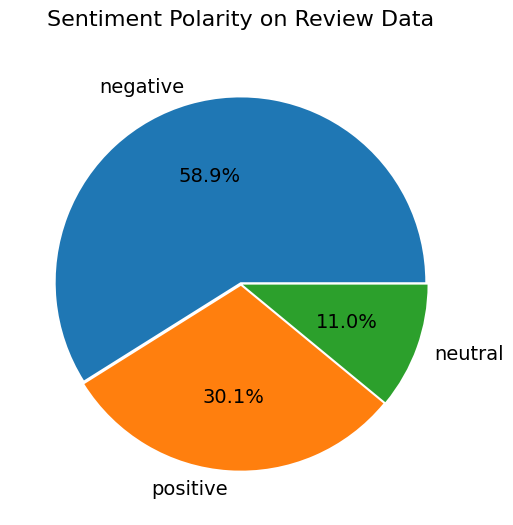

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in reviews['polarity'].value_counts()]
labels = list(reviews['polarity'].value_counts().index)
explode = [0.01] * len(labels)

# Autopct = menampilkan persentase di dalam setiap potongan pie.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()

### **Make DataFrame for Each Polarity**

In [48]:
# Membuat DataFrame baru 'positive_reviews' yang hanya berisi review dengan polaritas positif.
positive_reviews = reviews[reviews['polarity'] == 'positive']
positive_reviews = positive_reviews[['content','text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_reviews = positive_reviews.sort_values(by='polarity_score', ascending=False)
positive_reviews = positive_reviews.reset_index(drop=True)
positive_reviews.index += 1
positive_reviews.head()

,content,text_akhir,polarity_score,polarity,text_stopword
1,"Tiktok memberikan kenyamanan untuk para pengguna beraktivitas dalam silaturahmi dan kebutuhan dalam belanja secara online dan memberikan diskon besar , gratis ongkir bisa cod dan bagiyang beruntung akan mendapatkan paylater yang bisa digunaka untuk berbelanja trimakasih sudah memberikan segalanya kenyamanan dalam aktivitas dan interaksi bersama .salam menuju kesuksesan yang tak terduga",tiktok kenyamanan pengguna beraktivitas silaturahmi kebutuhan belanja online diskon gratis ongkos kirim cod bagiyang beruntung paylater digunaka berbelanja trimakasih kenyamanan aktivitas interaksi salam kesuksesan terduga,29,positive,"[tiktok, kenyamanan, pengguna, beraktivitas, silaturahmi, kebutuhan, belanja, online, diskon, gratis, ongkos, kirim, cod, bagiyang, beruntung, paylater, digunaka, berbelanja, trimakasih, kenyamanan, aktivitas, interaksi, salam, kesuksesan, terduga]"
2,"Resolusi pas nonton Live sering rubah sendiri, saya set di 360p tapi beberapa saat kemudian bisa berubah sendiri menjadi Original. Sering terjadi pas nonton live di Web/ browser. Soalnya ini kecepatan internet saya engga cukup buat nonton di resolusi tinggi. LIVE STREAMING SERING GANTI RESOLUSI SENDIRI. SAMA SERING BUFFER LIVENYA, LIVE NYA DOANG BUFFER TAPI KOMENTAR NYA MASI JALAN. TOLONG HELP US, TASUKETE KUDASAI. ONEGAISHIMASU.",resolusi nonton live rubah set p berubah original nonton live web browser kecepatan internet engga nonton resolusi live streaming ganti resolusi buffer livenya live doang buffer komentar masi jalan tolong help us tasukete kudasai onegaishimasu,28,positive,"[resolusi, nonton, live, rubah, set, p, berubah, original, nonton, live, web, browser, kecepatan, internet, engga, nonton, resolusi, live, streaming, ganti, resolusi, buffer, livenya, live, doang, buffer, komentar, masi, jalan, tolong, help, us, tasukete, kudasai, onegaishimasu]"
3,Saya sangat suka ini tapi kenapa ya sejak ada live saya gak bisa ngapa ngapain saya sudah ke keyboard saya kok gak bisa kenapa ya dan semenjak ada fitur live itu jadi susah Pengen like video orang tolong di perbaiki ya oh iya satu lagi tolong jangan live orang dimasuki di Vidio saya jadi susah juga mau lihat Vidio sendiri tolong di perbaiki ya dan saya masih kasih bintang 5 kalo belum di perbaiki saya kurangi bintang nya terima kasih assalamualaikum warahmatullahi mudah mudahan bermanfaat yaa 😊,suka live ngapa keyboard semenjak fitur live susah pengen like video orang tolong perbaiki oh tolong live orang dimasuki vidio susah lihat vidio tolong perbaiki kasih bintang perbaiki kurangi bintang terima kasih assalamualaikum warahmatullahi mudah mudahan bermanfaat,28,positive,"[suka, live, ngapa, keyboard, semenjak, fitur, live, susah, pengen, like, video, orang, tolong, perbaiki, oh, tolong, live, orang, dimasuki, vidio, susah, lihat, vidio, tolong, perbaiki, kasih, bintang, perbaiki, kurangi, bintang, terima, kasih, assalamualaikum, warahmatullahi, mudah, mudahan, bermanfaat]"
4,Sya kasih 3 bintang dlu. Dan saran saya tolong saat mau penarikan tolong jngan pake premium dana.pake lah akum dana biasa biar pengguna tiktok yaman denga ive ini.sedngkan yg bkin akun dana premium belum tentu berhasil min.tolong di respon.terimakasih,sya kasih bintang saran tolong penarikan tolong jngan pakai premium dana pakai akum dana biar pengguna tiktok yaman denga ive sedngkan bkin akun dana premium berhasil min tolong respon terimakasih,28,positive,"[sya, kasih, bintang, saran, tolong, penarikan, tolong, jngan, pakai, premium, dana, pakai, akum, dana, biar, pengguna, tiktok, yaman, denga, ive, sedngkan, bkin, akun, dana, premium, berhasil, min, tolong, respon, terimakasih]"
5,"Assalamualaikum,,trimakasih banyak kpd tuan tiktok, sya mrasa nyaman & tnang setelah mengikuti jejak langkah d aplikasi ini,dgn senang hati,bsa berteman lebih banyak,&bsa berbagi pengalaman hidup,& aq sangt snang dgn sgala apapun,sya sneng bsa mnerima komentar dr tmn2 smua,& sya jga sneng bsa mndoa

In [50]:
# Membuat DataFrame baru 'negative_reviews' yang hanya berisi tweet dengan polaritas negatif.
negative_reviews = reviews[reviews['polarity'] == 'negative']
negative_reviews = negative_reviews[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_reviews = negative_reviews.sort_values(by='polarity_score', ascending=True)
negative_reviews = negative_reviews[0:10]
negative_reviews = negative_reviews.reset_index(drop=True)
negative_reviews.index += 1
negative_reviews.head()

,text_akhir,polarity_score,polarity,text_stopword
1,iklan tai bau curang program catur tantang berani lawan main langkah iklan kalah dasar pengecut curang curi poin persentase program bikin kesel klu program pergi game catur dasar bego bikin kesel hujat pengecut lawan catur dasar catur brengsek kaya tai,-57,negative,"[iklan, tai, bau, curang, program, catur, tantang, berani, lawan, main, langkah, iklan, kalah, dasar, pengecut, curang, curi, poin, persentase, program, bikin, kesel, klu, program, pergi, game, catur, dasar, bego, bikin, kesel, hujat, pengecut, lawan, catur, dasar, catur, brengsek, kaya, tai]"
2,normal download lancar download ulang buka aplikasi tertera open sistem muncul nyoba buka aplikasi ketiga open play store open hadeh gini aplikasi kebanyakan tingkah device lawas dikit tinggalkan mandang versi android sdk arsitektur minimal arm gpu high hadeh males netep ig enak payah,-49,negative,"[normal, download, lancar, download, ulang, buka, aplikasi, tertera, open, sistem, muncul, nyoba, buka, aplikasi, ketiga, open, play, store, open, hadeh, gini, aplikasi, kebanyakan, tingkah, device, lawas, dikit, tinggalkan, mandang, versi, android, sdk, arsitektur, minimal, arm, gpu, high, hadeh, males, netep, ig, enak, payah]"
3,tolong kali donlod pakai aplikasi jelek alasannya masuk aplikasi pemberitahuan cache penuh hapus cache cache aplikasi bilang bodoh aplikasi perbaiki canggih canggih jelek tolong aplikasi perbaiki capek masuk aplikasi capek donlod perbaiki min,-44,negative,"[tolong, kali, donlod, pakai, aplikasi, jelek, alasannya, masuk, aplikasi, pemberitahuan, cache, penuh, hapus, cache, cache, aplikasi, bilang, bodoh, aplikasi, perbaiki, canggih, canggih, jelek, tolong, aplikasi, perbaiki, capek, masuk, aplikasi, capek, donlod, perbaiki, min]"
4,tiktok jelek masuk tiktok nunggu suruh hp rusak gara gara tiktok membuka tiktok hp rusak tiktok jelek tolong diperbaiki kaya gini kasih bintang sajaa tiktok jelek jelek ruang penyimpanan data penuh tiktok jelek,-43,negative,"[tiktok, jelek, masuk, tiktok, nunggu, suruh, hp, rusak, gara, gara, tiktok, membuka, tiktok, hp, rusak, tiktok, jelek, tolong, diperbaiki, kaya, gini, kasih, bintang, sajaa, tiktok, jelek, jelek, ruang, penyimpanan, data, penuh, tiktok, jelek]"
5,lumayan lumayan jelek suruh download kali pakai wifi rugi download aplikasi sinyal bagus ngelek aplikasi tai anjing babi jerapah kucing tolol,-42,negative,"[lumayan, lumayan, jelek, suruh, download, kali, pakai, wifi, rugi, download, aplikasi, sinyal, bagus, ngelek, aplikasi, tai, anjing, babi, jerapah, kucing, tolol]"


In [51]:
# Membuat DataFrame baru 'neutral_reviews' yang hanya berisi tweet dengan polaritas netral.
neutral_reviews = reviews[reviews['polarity'] == 'neutral']
neutral_reviews = neutral_reviews[['content', 'text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_reviews = neutral_reviews.sort_values(by='polarity_score', ascending=True)
neutral_reviews = neutral_reviews[0:10]
neutral_reviews = neutral_reviews.reset_index(drop=True)
neutral_reviews.index += 1
neutral_reviews.head()

,content,text_akhir,polarity_score,polarity,text_stopword
1,"makin kesini makin gak ngerti sering banget aplikasinya gak bisa dibuka cuma muncul logo tiktok nya doang,,ujung²nya harus re-instal lagi🤦‍♀️",kesini mengerti aplikasinya dibuka muncul logo tiktok doang ujungnya reply instal,0,neutral,"[kesini, mengerti, aplikasinya, dibuka, muncul, logo, tiktok, doang, ujungnya, reply, instal]"
2,"Saya kurang nyaman posting sesuatu di tiktok sekarang,karena tiktok berat sebelah,postingan yang tidak unsur pelanggaran pun kena peringatan sungguh aneh",nyaman posting tiktok tiktok berat sebelah postingan unsur pelanggaran kena peringatan sungguh aneh,0,neutral,"[nyaman, posting, tiktok, tiktok, berat, sebelah, postingan, unsur, pelanggaran, kena, peringatan, sungguh, aneh]"
3,untuk tiktok indonesia anda sangat tidak profesional,tiktok indonesia profesional,0,neutral,"[tiktok, indonesia, profesional]"
4,"Baru di update padahal,udah gabisa dibuka lagi. ni kenapa ni,jelaskan🥲",update gabisa dibuka,0,neutral,"[update, gabisa, dibuka]"
5,ntah kanapah tik tok sekarang lemot banget setiap kali buka selalu mati terus jadi harus di ulang ulang,ntah kanapah tik tok lambat kali buka mati ulang ulang,0,neutral,"[ntah, kanapah, tik, tok, lambat, kali, buka, mati, ulang, ulang]"


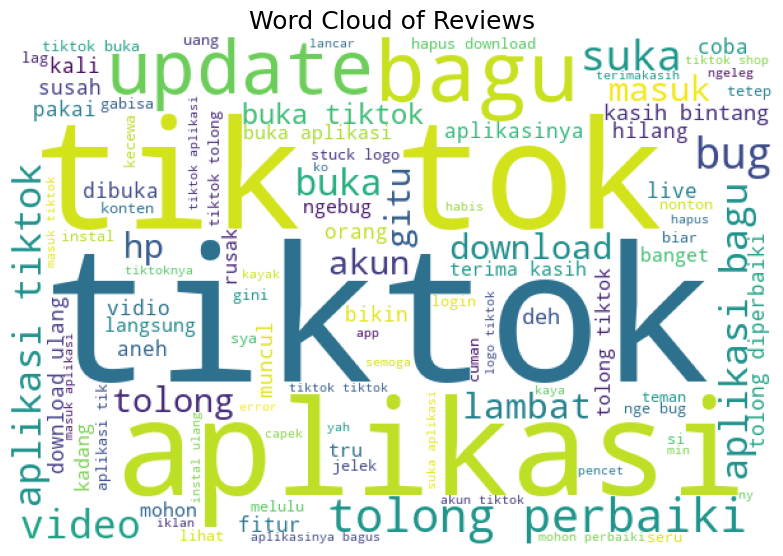

In [53]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan.
list_words = ''

# Iterasi melalui setiap review dalam kolom 'text_stopword' dari DataFrame 'reviews'.
for review in reviews['text_stopword']:
    for word in review:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Reviews', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

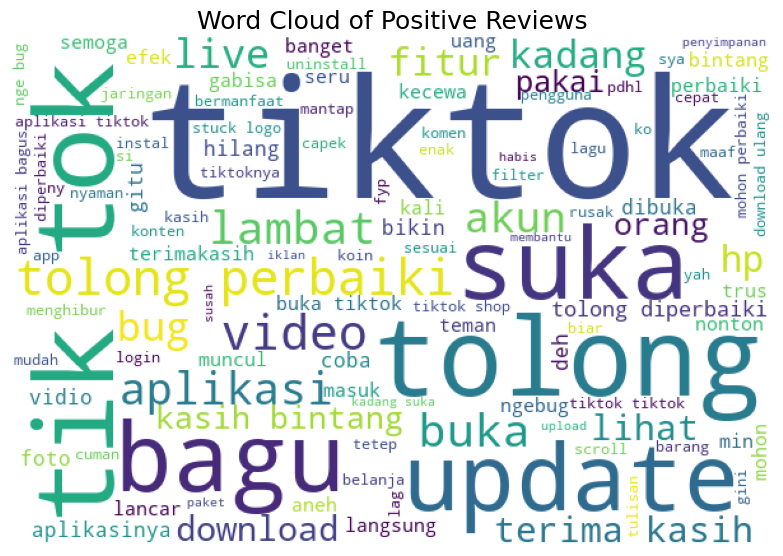

In [54]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam review positif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_reviews'.
for tweet in positive_reviews['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Reviews', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

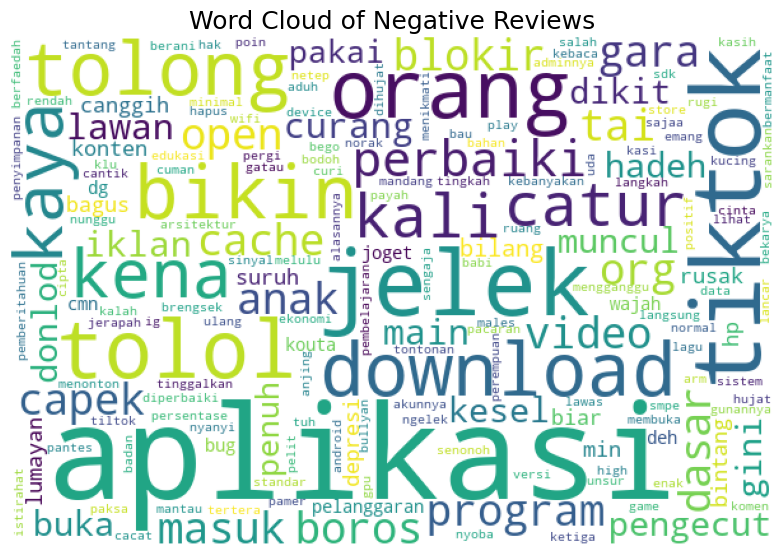

In [55]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam review negatif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_reviews'.
for tweet in negative_reviews['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Reviews', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

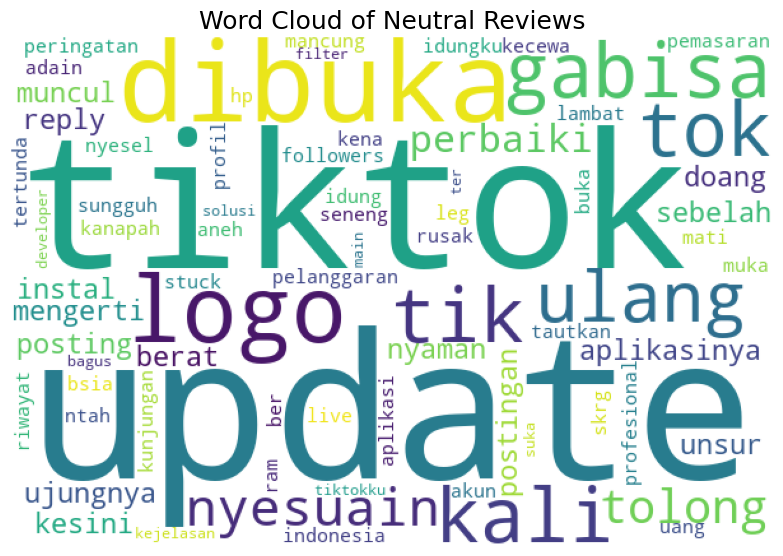

In [57]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam review netral.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'neutral_reviews'.
for tweet in neutral_reviews['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Reviews', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

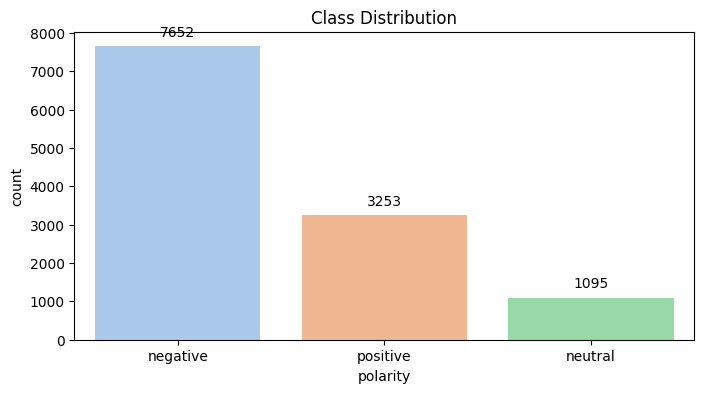

In [ ]:
plt.figure(figsize=(8, 4))

# Check class distribution
class_dist_plot = sns.countplot(x='polarity', data=reviews, palette='pastel', hue='polarity', legend=False)
plt.title('Class Distribution')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

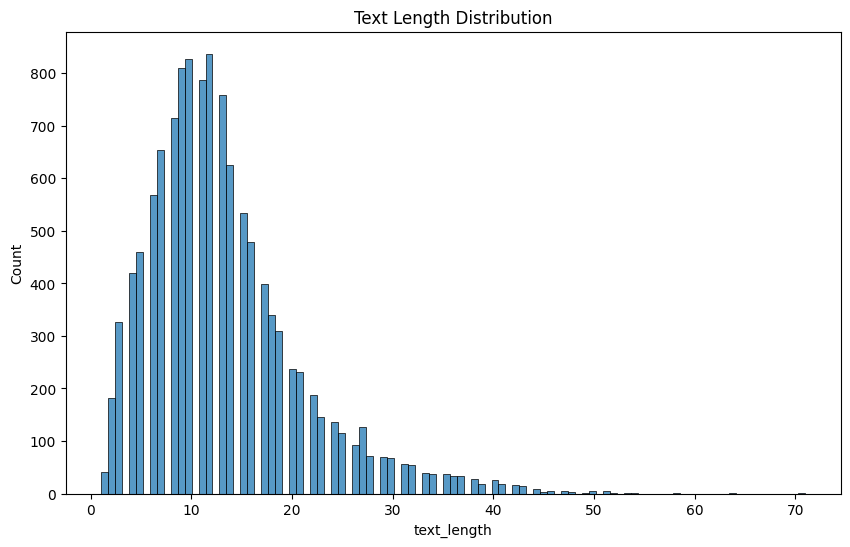

In [63]:
plt.figure(figsize=(10, 6))

# Visualize text length distribution
reviews['text_length'] = reviews['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(reviews['text_length'])
plt.title('Text Length Distribution')
plt.show()

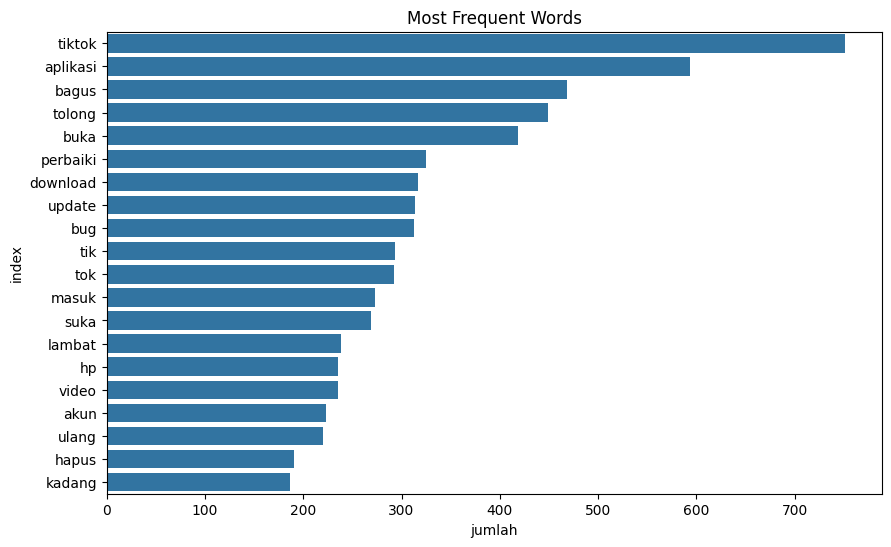

In [68]:
plt.figure(figsize=(10, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(reviews['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

# **Data Splitting**

In [69]:
reviews.head(2)

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity,text_length
0,"kenapa tiktok sering sekali tidak bisa di buka selalu ngestak di logo tiktok,sering sekali harus ulang download apk tiktok,gara' tidak bisa di buka,benerin dong bug tiktokny jadi olok kuota,makasi",kenapa tiktok sering sekali tidak bisa di buka selalu ngestak di logo tiktok sering sekali harus ulang download apk tiktok gara tidak bisa di buka benerin dong bug tiktokny jadi olok kuota makasi,kenapa tiktok sering sekali tidak bisa di buka selalu ngestak di logo tiktok sering sekali harus ulang download apk tiktok gara tidak bisa di buka benerin dong bug tiktokny jadi olok kuota makasi,kenapa tiktok sering sekali tidak bisa di buka selalu stuck di logo tiktok sering sekali harus ulang download aplikasi tiktok gara tidak bisa di buka benerin dong bug tiktoknya jadi boros kuota makasi,"[kenapa, tiktok, sering, sekali, tidak, bisa, di, buka, selalu, stuck, di, logo, tiktok, sering, sekali, harus, ulang, download, aplikasi, tiktok, gara, tidak, bisa, di, buka, benerin, dong, bug, tiktoknya, jadi, boros, kuota, makasi]","[tiktok, buka, stuck, logo, tiktok, ulang, download, aplikasi, tiktok, gara, buka, benerin, bug, tiktoknya, boros, kuota, makasi]",tiktok buka stuck logo tiktok ulang download aplikasi tiktok gara buka benerin bug tiktoknya boros kuota makasi,-15,negative,17
1,"suka banget dengan update an tiktok sekarang, Setiap menonton video, ada koin. jadi koinnya bisa bertambah lagi deh.... kalau mau update jangan lupa ditambah dengan koin seperti ini ya kak, biar rajin nonton 😁",suka banget dengan update an tiktok sekarang Setiap menonton video ada koin jadi koinnya bisa bertambah lagi deh kalau mau update jangan lupa ditambah dengan koin seperti ini ya kak biar rajin nonton,suka banget dengan update an tiktok sekarang setiap menonton video ada koin jadi koinnya bisa bertambah lagi deh kalau mau update jangan lupa ditambah dengan koin seperti ini ya kak biar rajin nonton,suka sekali dengan update an tiktok sekarang setiap menonton video ada koin jadi koinnya bisa bertambah lagi deh kalau mau update jangan lupa ditambah dengan koin seperti ini iya kak biar rajin nonton,"[suka, sekali, dengan, update, an, tiktok, sekarang, setiap, menonton, video, ada, koin, jadi, koinnya, bisa, bertambah, lagi, deh, kalau, mau, update, jangan, lupa, ditambah, dengan, koin, seperti, ini, iya, kak, biar, rajin, nonton]","[suka, update, tiktok, menonton, video, koin, koinnya, bertambah, deh, update, lupa, ditambah, koin, kak, biar, rajin, nonton]",suka update tiktok menonton video koin koinnya bertambah deh update lupa ditambah koin kak biar rajin nonton,-6,negative,17


In [70]:
X = reviews['text_akhir']
y = reviews['polarity']

In [71]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

In [72]:
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,admin,akun,aman,anak,aneh,apknya,aplikasi,aplikasinya,app,bagus,...,uninstal,uninstall,update,upload,versi,video,videonya,vidio,wifi,yah
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.133957,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.377778,0.0,0.0,0.201196,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.132491,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.424984,0.0,0.0,0.538782,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
11996,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
11997,0.0,0.268827,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.330466,0.0,0.0
11998,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [74]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# **Modelling**